# Description

Notebook by Omogbai Oleghe (o.oleghe@ritepaklimited.com)

It is a simple notebook to model how three edge computing nodes service a geographical area. The nodes are resource constrained by CPU. The simulation process has been modelled using simpy (https://simpy.readthedocs.io/en/latest/)

ipyleaflet (https://ipyleaflet.readthedocs.io/en/latest/) has been used to model
a geographical area to show when/where tasks are received. Popup markers are used to indicate the states of tasks from queuing to processing to finished. Blue markers (with Q) indicate tasks in queue. Green markers (with rotating gear) indicates tasks in process. Red markers for finished tasks are slightly opaque. The node locations have been indicated using three markers (masts).

In this simulation model, tasks tasks or computing requests are assigend to the closest node by distance, mimicng a location-aware task placement policy

A custom marker (car) has been used to mimic a moving car. In this notebook, the moving car is simply an object, just used to show how to add a moving object. Moving cars will be used to model V2X and V2V edge computing

ipywidgets (https://ipywidgets.readthedocs.io/) has been used to create the interactive GUIs

Matplotlib (https://matplotlib.org) has been used for graphing purposes.

Custom icons for the markers are from https://fontawesome.com
Custom car and mast markers from https://www.flaticon.com
Ant path coordinates were obtained using https://www.maps.ie/map-my-route/

## Set up for the map

In [1]:
# import the map modules
from ipyleaflet import (Map, Circle, Marker, MeasureControl, AwesomeIcon, 
                        Popup, FullScreenControl, AntPath, Icon, WidgetControl)
from ipywidgets import (FloatSlider, IntSlider, interact, interactive, fixed, interact_manual, jslink, 
FloatProgress, VBox, HTML)
import ipywidgets as widgets
from threading import Thread
from IPython.display import display

# import the simulation modules
import simpy
import numpy as np

# import package for computing distance
import mpu

# import the pacakge for plotting the charts
import matplotlib.pyplot as plt

In [2]:
# set the center coordinates of the map
center_lat = 6.515
center_lon = 3.394

In [3]:
# create the map widget
m = Map(center=(center_lat, center_lon), zoom=15)

## Create custom icons for the map

In [4]:
# icon for marker to indicate task that is in process. The main marker (marker) icon is 
# dynamically changed within the service_task_in_node function in the simpy-based model 
# later on
icon1 = AwesomeIcon(name='fas fa-cog', marker_color='green',
                    icon_color='black', spin=True)

# icon for marker to indicate task has completed. The main marker (marker) icon is 
# dynamically changed within the service_task_in_node function in the simpy-based model 
# later on
icon2 = AwesomeIcon(name='check-circle', marker_color='red', icon_color='black')

# icon for marker to show the cell site on the map
icon3 = Icon(icon_url='https://image.flaticon.com/icons/png/512/62/62501.png', 
             icon_size=[25,60], icon_anchor=[25,60])

# icon (Q) for main marker to indicate task is in queue
icon4 = AwesomeIcon(name='fab fa-quora', marker_color='blue', icon_color='black')

# icon for moving marker
icon5 = Icon(icon_url='https://image.flaticon.com/icons/png/512/3202/3202926.png', 
             icon_size=[30, 30])

# Set up the markers and ant paths

In [5]:
# This is the main marker, that will change icon states. Here it is instantiated.
marker = Marker(location=(6.514253317659667, 3.3933971689342877), icon=icon4)

In [6]:
# location for node0
node0_lat = 6.516060111018401
node0_lon = 3.3942876621261657

# location for node1
node1_lat = 6.5129475190442365
node1_lon = 3.391069011343227

# location for node2
node2_lat = 6.518874218644982
node2_lon = 3.3970771594713787


In [7]:
# markers for the nodes
node0 = Marker(location=(node0_lat, node0_lon), icon=icon3)
node1 = Marker(location=(node1_lat, node1_lon), icon=icon3)
node2 = Marker(location=(node2_lat, node2_lon), icon=icon3)

In [8]:
# add to node markers to the map
m.add_layer(node0)
m.add_layer(node1)
m.add_layer(node2)

In [9]:
# finished marker to indicate simulation has ended
finished_message = HTML()
finished_message.value = "SIMULATION HAS ENDED"
# popup at a given location on the map
finished = Popup(location=(6.519758953787167, 3.393086032629793),
                 child=finished_message, close_button=False,
                auto_close=False, close_on_escape_key=False)

In [10]:
# add to the map, a circle to denote the network area
circle = Circle(location=(center_lat, center_lon), radius=700,
                color="red", fill_opacity=0.05, weight=2)
m.add_layer(circle)

In [11]:
# add to the map, full screen control
m.add_control(FullScreenControl())

In [12]:
# add the ant path for the mobile user
ant_path = AntPath(
    locations=[
             [6.51746, 3.387809],  [6.517765, 3.38888],  
        [6.51787, 3.389167],  [6.518012, 3.389444],  [6.518155, 3.389655],  [6.518613, 3.390258],  
        [6.518714, 3.390429],  [6.518853, 3.390723],  [6.518918, 3.390906],  [6.518962, 3.391101],  
        [6.518987, 3.391336],  [6.518953, 3.39136],  [6.518938, 3.391409],  [6.518958, 3.391456],  
        [6.518996, 3.391478],  [6.519081, 3.392472],  [6.519061, 3.392809],  [6.518588, 3.395111],  
        [6.518573, 3.395146],  [6.518581, 3.395172],  [6.518524, 3.395528],  [6.518519, 3.395746],  
        [6.518543, 3.395964],  [6.518633, 3.396351],  [6.518885, 3.396932],  [6.518885, 3.396951],  
        [6.518558, 3.397097],  [6.518337, 3.397163],  [6.51809, 3.397207],  [6.5181, 3.397415],  
        [6.517817, 3.397375],  [6.517817, 3.397375],  [6.517697, 3.397358],  [6.517421, 3.397361],  
        [6.517129, 3.397372],  [6.517122, 3.39718],  [6.516851, 3.397201],  [6.516615, 3.397247],  
        [6.516186, 3.397415],  [6.515613, 3.397588],  [6.515248, 3.39763],  [6.514928, 3.397589],  
        [6.514331, 3.397446],  [6.513938, 3.397392],  [6.513805, 3.397393],  [6.513803, 3.39705],  
        [6.513803, 3.39705],  [6.5138, 3.395799],  [6.513733, 3.395255],  [6.513587, 3.394569],  
        [6.51326, 3.393188],  [6.512997, 3.39195],  [6.512791, 3.391198],  [6.512791, 3.391198],  
        [6.512766, 3.391138],  [6.512776, 3.391118], [6.512986, 3.391188],  [6.515244, 3.39174],  
        [6.515645, 3.39179],  [6.516234, 3.391781],  [6.5174, 3.391643],  [6.5174, 3.391643], 
        [6.518958, 3.391456],  [6.518996, 3.391478],  [6.519062, 3.391459],  [6.519084, 3.391414],  
        [6.518946, 3.390819],  [6.518845, 3.39055],  [6.518786, 3.390418],  [6.518631, 3.390174],  
        [6.518152, 3.38954],  [6.518025, 3.389333],  [6.517852, 3.388948],  [6.51758, 3.388034],  
        [6.517636, 3.387979],  [6.517604, 3.387691], [6.51746, 3.387809],  [6.517765, 3.38888],  
        [6.51787, 3.389167],  [6.518012, 3.389444],  [6.518155, 3.389655],  [6.518613, 3.390258],  
        [6.518714, 3.390429],  [6.518853, 3.390723],  [6.518918, 3.390906],  [6.518962, 3.391101],  
        [6.518987, 3.391336],  [6.518953, 3.39136],  [6.518938, 3.391409],  [6.518958, 3.391456],  
        [6.518996, 3.391478],  [6.519081, 3.392472],  [6.519061, 3.392809],  [6.518588, 3.395111],  
        [6.518573, 3.395146],  [6.518581, 3.395172],  [6.518524, 3.395528],  [6.518519, 3.395746],  
        [6.518543, 3.395964],  [6.518633, 3.396351],  [6.518885, 3.396932],  [6.518885, 3.396951],  
        [6.518558, 3.397097],  [6.518337, 3.397163],  [6.51809, 3.397207],  [6.5181, 3.397415],  
        [6.517817, 3.397375],  [6.517817, 3.397375],  [6.517697, 3.397358],  [6.517421, 3.397361],  
        [6.517129, 3.397372],  [6.517122, 3.39718],  [6.516851, 3.397201],  [6.516615, 3.397247],  
        [6.516186, 3.397415],  [6.515613, 3.397588],  [6.515248, 3.39763],  [6.514928, 3.397589],  
        [6.514331, 3.397446],  [6.513938, 3.397392],  [6.513805, 3.397393],  [6.513803, 3.39705],  
        [6.513803, 3.39705],  [6.5138, 3.395799],  [6.513733, 3.395255],  [6.513587, 3.394569],  
        [6.51326, 3.393188],  [6.512997, 3.39195],  [6.512791, 3.391198],  [6.512791, 3.391198],  
        [6.512766, 3.391138],  [6.512776, 3.391118], [6.512986, 3.391188],  [6.515244, 3.39174],  
        [6.515645, 3.39179],  [6.516234, 3.391781],  [6.5174, 3.391643],  [6.5174, 3.391643], 
        [6.518958, 3.391456],  [6.518996, 3.391478],  [6.519062, 3.391459],  [6.519084, 3.391414],  
        [6.518946, 3.390819],  [6.518845, 3.39055],  [6.518786, 3.390418],  [6.518631, 3.390174],  
        [6.518152, 3.38954],  [6.518025, 3.389333],  [6.517852, 3.388948],  [6.51758, 3.388034],  
        [6.517636, 3.387979],  [6.517604, 3.387691]

    ],
    dash_array=[1, 10],
    delay=1000,
    color='#7590ba',
    pulse_color='#3f6fba'
)

In [13]:
# add the ant path to the map
m.add_layer(ant_path)

In [14]:
# the moving marker
marker2 = Marker(location=(6.51746, 3.387809), icon=icon5, rotation_angle=0)

In [15]:
# add the marker2 to the map
m.add_layer(marker2)

# Set up the controls and interactactive widgets

In [16]:
# add sliders 
# for simulation speed
speed_slider = widgets.FloatSlider(description='Run speed', value= 0.05, min=0.05, max=1, step=0.05)

# for simulation run time
runtime_slider = widgets.IntSlider(description='Run time', value=100, min=50, max=200, step=50)

# for minimum cpu that can be requested
min_cpu_slider = widgets.IntSlider(description='Min CPU', min=100, max=300, step=50)

# for maximum cpu that can be requested
max_cpu_slider = widgets.IntSlider(description='Max CPU', min=300, max=1200, step=100)

# for progress bar
sim_status = widgets.FloatProgress(
    value=0,
    min=0,
    max=100,
    step=0.1,
    description='Running...',
    bar_style='success', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
# progress_bar =  WidgetControl(widget=sim_status, position='topright')

In [17]:
gui_box =  WidgetControl(widget=VBox([min_cpu_slider, max_cpu_slider,
                                     speed_slider, runtime_slider, sim_status]), position='topright')

In [18]:
m.add_control(gui_box)

# Display the developed map, adjust the simulation paramters and run the simulation

In [19]:
# display the map
m

Map(center=[6.515, 3.394], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [20]:
# additional variables for statistics
total_in_append = []
tasks_processing_append = []
still_processing_append = []
total_out_append = []
tasks_in_queue_append = []
simulation_time_append = []
cpu0_util_append = []
cpu1_util_append = []
cpu2_util_append = []
schedule_id = 0

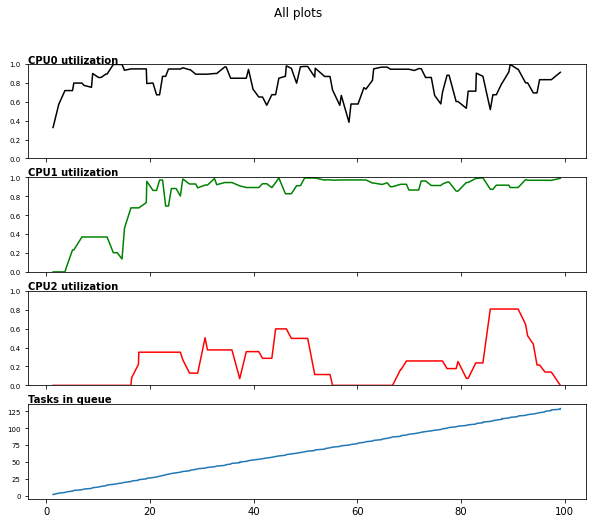

In [21]:
# the python script for the simulation model

simulation_run_time = runtime_slider.value
sim_status.max = runtime_slider.value
ant_path_coord_index = 0

class TaskGenerator:
    """Class to generate tasks"""

    def __init__(self, env):
        self.env = env
        self.cpu_requested = 0
        self.task_id = 0
        self.process_time = 0
        self.marker = marker
        self.initiate = env.process(self.generate_task())
        self.loc_lat = 0
        self.loc_lon = 0
        

    def generate_task(self):
        global m
        global marker
        global marker2
        global ant_path_coord_index
        global speed
        global schedule_id
        

        while True:
            # inter arrival time for tasks
            inter_arrival = np.random.uniform(1, 2)
            
            # append the task to the list
            total_in_append.append(1)
            
            # task id
            self.task_id += 1
            
            # task requested cpu
            self.cpu_requested = np.random.randint(min_cpu_slider.value, max_cpu_slider.value)
            
            # normal duration time to process the task
            self.process_time = np.random.randint(5, 15)

            # task request location coordinates
            self.loc_lat = np.random.uniform(6.509, 6.519)
            self.loc_lon = np.random.uniform(3.39, 3.3985)

            # Assign a schedule id depending on distance of task from each node.
            # For example, if task is nearest to node0 then the schedule id = 0
            # First measure the distance between the generated task and each node
            dist_to_node0 = mpu.haversine_distance((self.loc_lat, self.loc_lon), 
                                                   (node0_lat, node0_lon))
            dist_to_node1 = mpu.haversine_distance((self.loc_lat, self.loc_lon), 
                                                   (node1_lat, node1_lon))
            dist_to_node2 = mpu.haversine_distance((self.loc_lat, self.loc_lon), 
                                                   (node2_lat, node2_lon))
            
            # set schedule ids
            if dist_to_node0 < dist_to_node1 and dist_to_node0 < dist_to_node2:
                schedule_id = 0
            elif dist_to_node1 < dist_to_node2 and dist_to_node1 < dist_to_node0:
                schedule_id = 1
            else:
                schedule_id = 2
            
            # record the time that the task came in
            time_in = round(self.env.now, 1)
            
            # the popup for task location
            marker_popup = HTML()
            marker_popup.value = f"Task received at time={time_in}, " \
                                 f"cpu requested={self.cpu_requested}, " \
                                 f"loc lat={round(self.loc_lat, 5)}, " \
                                 f"loc lon={round(self.loc_lon, 5)}"
            self.marker = Marker(location=(self.loc_lat, self.loc_lon),
                                 icon=icon4, popup=marker_popup)
            m.add_layer(self.marker)
            
            # the marker for the moving user is added
            ant_path_coord_index += 1
            try:
                marker2.location = ant_path.locations[ant_path_coord_index]
            except IndexError: # avoid end of list range error
                marker2.location = ant_path.locations[-1] # stop at the last position
          
            # display the updated map
            m
            
            # servicing of task
            self.env.process(ServiceTask(self.env,
                                         self.cpu_requested,
                                         self.process_time,
                                         self.marker,
                                         self.task_id).service_task_in_node())
            
            # yield next task generation
            yield self.env.timeout(inter_arrival)
            
            # tasks in queue
            tasks_in_system = len(total_in_append) - len(total_out_append)
            tasks_in_process = len(tasks_processing_append) - len(total_out_append)
            if tasks_in_process > tasks_in_system:
                tasks_in_queue = 0
            else:
                tasks_in_queue = tasks_in_system - tasks_in_process
            
            # update the progress bar
            sim_status.value = self.env.now
            
            # cpu utilization
            cpu0_util = (cpu_node0.capacity - cpu_node0.level) / cpu_node0.capacity
            cpu1_util = (cpu_node1.capacity - cpu_node1.level) / cpu_node1.capacity
            cpu2_util = (cpu_node2.capacity - cpu_node2.level) / cpu_node2.capacity

            # parameters to graph
            simulation_time_append.append(self.env.now)
            tasks_in_queue_append.append(tasks_in_queue)
            cpu0_util_append.append(cpu0_util)
            cpu1_util_append.append(cpu1_util)
            cpu2_util_append.append(cpu2_util)
            

class ServiceTask:
    """Class to process the task"""

    def __init__(self, env, cpu_requested, process_time, marker, task_id):
        self.env = env
        self.cpu_requested = cpu_requested
        self.process_time = process_time
        self.marker = marker
        self.task_id = task_id

    def service_task_in_node(self):
        global m
        
        for i in range(3):
            if schedule_id == i:
                # seize the requested cpu
                yield cpu_resources[i].get(self.cpu_requested)

                # change the icon to indicate service state
                self.marker.icon = icon1

                # process the task for a given process time
                yield self.env.timeout(self.process_time)

                # return the seized cpu
                yield cpu_resources[i].put(self.cpu_requested)
                
                # register the time that the task is completed
                time_out = self.env.now

                # change the icon to indicate finished state
                self.marker.icon = icon2

                # To indicate a completed task, make marker more opaque to see it darker.
                self.marker.opacity = 0.2
                
                # append the task to the total out
                total_out_append.append(1)

        
# run the simulation in real time. Simulation runs faster for factor value --> 0.001.
sim_env = simpy.rt.RealtimeEnvironment(factor=speed_slider.value, strict=False)

# set up the resources. Resource is setup using simpy container
cpu_node0 = simpy.Container(sim_env, init=1500, capacity=1500)
cpu_node1 = simpy.Container(sim_env, init=1500, capacity=1500)
cpu_node2 = simpy.Container(sim_env, init=1500, capacity=1500)
cpu_resources = [cpu_node0, cpu_node1, cpu_node2]

# start the simulation
actuate = TaskGenerator(sim_env)
sim_env.process(actuate.generate_task())

# run the simulation to a set time
sim_env.run(until=simulation_run_time)

# add the popup to indicate simulation has finished running.
m.add_layer(finished)

# make progress bar finished
sim_status.value = runtime_slider.value
sim_status.description='FINISHED!!!'

# plot the charts
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(10,8))
fig.suptitle('All plots')
ax1.plot(simulation_time_append, cpu0_util_append, 'k')
ax1.set_title('CPU0 utilization', loc='left', fontsize=10, fontweight='bold', pad=1)
ax1.tick_params(axis='y', which='major', labelsize=7)
ax1.set_ylim([0, 1])
ax2.plot(simulation_time_append, cpu1_util_append, 'g')
ax2.set_title('CPU1 utilization', loc='left', fontsize=10, fontweight='bold', pad=2)
ax2.tick_params(axis='y', which='major', labelsize=7)
ax2.set_ylim([0, 1])
ax3.plot(simulation_time_append, cpu2_util_append, 'r')
ax3.set_title('CPU2 utilization', loc='left', fontsize=10, fontweight='bold', pad=2)
ax3.tick_params(axis='y', which='major', labelsize=7)
ax3.set_ylim([0, 1])
ax4.plot(simulation_time_append, tasks_in_queue_append)
ax4.set_title('Tasks in queue', loc='left', fontsize=10, fontweight='bold', pad=2)
ax4.tick_params(axis='y', which='major', labelsize=7)
plt.show()

# Scroll up to view the map with animation